# Модель предпочтительного присоединения

В некоторую структуру (университет) последовательно, один за другим, прибывают новые
объекты (студенты). Первый прибывший создает структуру (клуб). Каждый очередной объект
с небольшой вероятностью $p$ создает новый клуб, или с вероятностью $1-p$ присоединятеся к
одному из уже имеющихся.

Вероятность присоединения к данному клубу пропорциональна его
размеру (числу членов), деленному на общее количество уже прибывших к данному моменту

Реализуем клубную систему

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class ClubSystem:
    
    def __init__(self, p = 0.1, clubs = []):
        self.p = p
        self.clubs = clubs
        self.peopleNum = 0
        self.weights = []
        if len(self.clubs) > 0:
            self.peopleNum = sum(self.clubs)
        self.weights = self.updateWeights()
        
    def step(self):
        if np.random.rand() < self.p or len(self.clubs) == 0:
            self.clubs.append(1)
        else:
            club = random.choices([m for m in range(len(self.clubs))], weights=self.weights, k = 1)[0]
            self.clubs[club] += 1
        self.peopleNum += 1
        self.updateWeights()
            
    def updateWeights(self):
        if len(self.clubs) == 0:
            self.weights = []
            return
        self.weights = [k / self.peopleNum for k in self.clubs]

Смоделируем поступление 100 студентов, зададим вероятность создания нового клуба $p=0.3$

In [3]:
people_max = 100
p = 0.3

itmo_clubs = ClubSystem(p=p)

In [4]:
for _ in range(people_max):
    itmo_clubs.step()

Text(0, 0.5, 'Число участников')

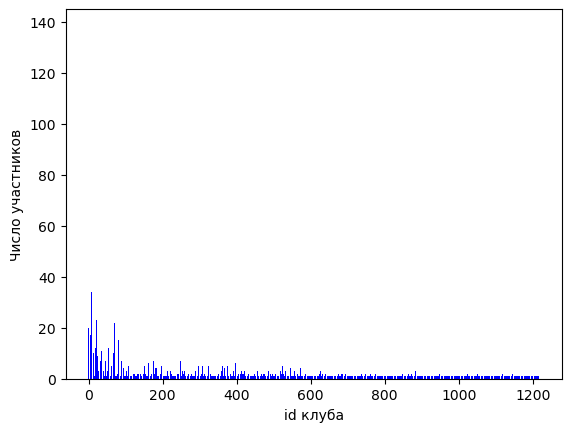

In [5]:
plt.bar((range(len(itmo_clubs.clubs))), itmo_clubs.clubs, color='blue')
plt.xlabel("id клуба")
plt.ylabel("Число участников")

Определим распределение клубов по числу участников

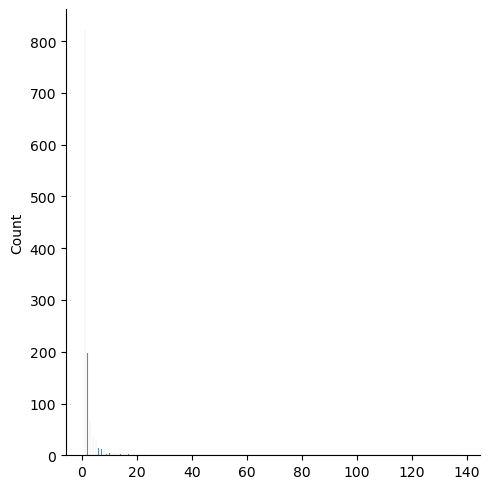

In [6]:
sns.displot(itmo_clubs.clubs)